In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
df = pd.read_csv('../data/raw/prompts_raw.csv')

print("="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Matplotlib is building the font cache; this may take a moment.


DATASET OVERVIEW
Total rows: 39,234
Total columns: 2

Column names: ['Prompt', 'isMalicious']

Data types:
Prompt           str
isMalicious    int64
dtype: object

Memory usage: 17.64 MB


In [2]:
# Display first few rows
print("\n" + "="*50)
print("FIRST 5 ROWS")
print("="*50)
print(df.head())

# Display last few rows (sometimes different patterns)
print("\n" + "="*50)
print("LAST 5 ROWS")
print("="*50)
print(df.tail())

# Basic info
print("\n" + "="*50)
print("DATA INFO")
print("="*50)
df.info()

# Summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)
print(df.describe(include='all'))


FIRST 5 ROWS
                                              Prompt  isMalicious
0  How did the "Coronation Street" storyline hand...            1
1                                 Login to Snapchat?            0
2  I've been having a hard time getting back into...            1
3           What is the best way to budget my money?            1
4  Is it rude to say that I don’t understand “Cau...            0

LAST 5 ROWS
                                                  Prompt  isMalicious
39229             Is induced current always alternating?            0
39230  Is Bran Stark so powerful that the Three Eyed ...            0
39231  I want to test the ability of students to read...            1
39232  Has Quora hired any professional writer to ans...            0
39233         What are the best three-player card games?            0

DATA INFO
<class 'pandas.DataFrame'>
RangeIndex: 39234 entries, 0 to 39233
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ----

In [3]:
print("\n" + "="*50)
print("MISSING VALUES")
print("="*50)
missing = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_table[missing_table['Missing Count'] > 0])

if missing.sum() == 0:
    print("✓ No missing values found!")


MISSING VALUES
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
✓ No missing values found!


In [7]:
print("\n" + "="*50)
print("DUPLICATE ANALYSIS")
print("="*50)

prompt_col = 'Prompt'
label_col = 'isMalicious'

total_duplicates = df.duplicated(subset=[prompt_col]).sum()
print(f"Total duplicate prompts: {total_duplicates:,} ({100*total_duplicates/len(df):.2f}%)")

# Check for exact duplicates (same prompt, same label)
exact_duplicates = df.duplicated().sum()
print(f"Exact duplicate rows: {exact_duplicates:,}")

# Check for conflicting labels (same prompt, different labels)
prompt_label_counts = df.groupby(prompt_col)[label_col].nunique()
conflicting = prompt_label_counts[prompt_label_counts > 1]
print(f"Prompts with conflicting labels: {len(conflicting):,}")

if len(conflicting) > 0:
    print("\nExample conflicts:")
    print(df[df[prompt_col].isin(conflicting.index)].sort_values(prompt_col).head(10))


DUPLICATE ANALYSIS
Total duplicate prompts: 0 (0.00%)
Exact duplicate rows: 0
Prompts with conflicting labels: 0


In [8]:
print("\n" + "="*50)
print("CLASS DISTRIBUTION")
print("="*50)

class_counts = df[label_col].value_counts()
print(class_counts)
print(f"\nClass balance:")
for label, count in class_counts.items():
    label_name = "Malicious" if label == 1 else "Benign"
    print(f"  {label_name}: {count:,} ({100*count/len(df):.2f}%)")

# Calculate imbalance ratio
majority_class = class_counts.max()
minority_class = class_counts.min()
imbalance_ratio = majority_class / minority_class
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("⚠️  Significant class imbalance detected!")
    print("   → Will need to use stratified sampling")
    print("   → Consider class weights in model training")
    print("   → Use appropriate metrics (F1, AUC-ROC, not accuracy)")


CLASS DISTRIBUTION
isMalicious
1    19617
0    19617
Name: count, dtype: int64

Class balance:
  Malicious: 19,617 (50.00%)
  Benign: 19,617 (50.00%)

Imbalance ratio: 1.00:1


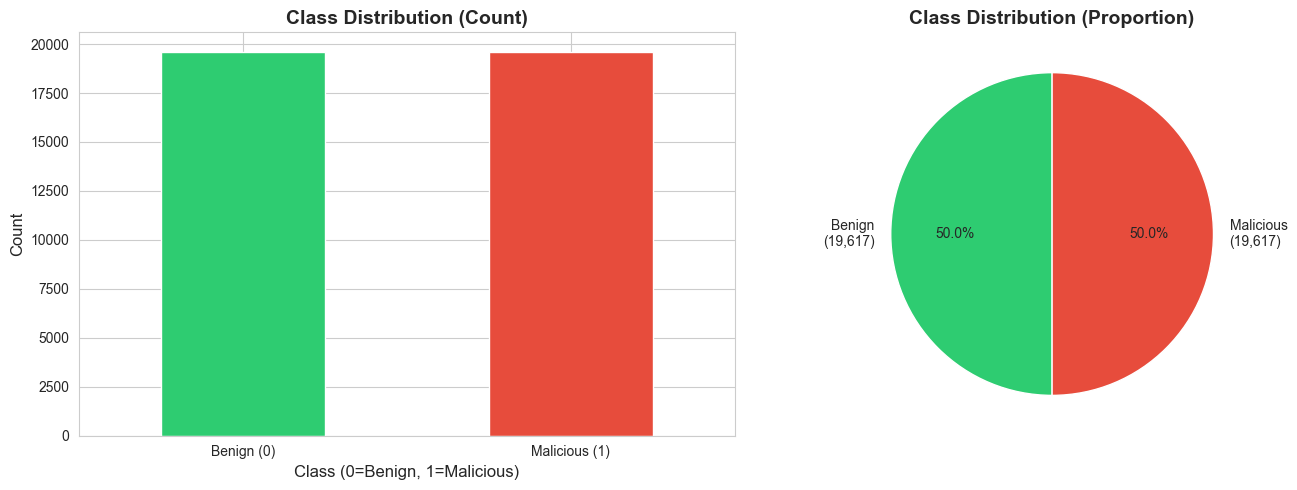

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Benign, 1=Malicious)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Benign (0)', 'Malicious (1)'], rotation=0)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
labels = [f'Benign\n({class_counts[0]:,})', f'Malicious\n({class_counts[1]:,})']
axes[1].pie(class_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Proportion)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
print("\n" + "="*50)
print("PROMPT LENGTH ANALYSIS")
print("="*50)

# Calculate lengths
df['prompt_length'] = df[prompt_col].astype(str).apply(len)
df['word_count'] = df[prompt_col].astype(str).apply(lambda x: len(x.split()))

# Statistics by class
print("\nLength statistics by class:")
print(df.groupby(label_col)['prompt_length'].describe())

print("\nWord count statistics by class:")
print(df.groupby(label_col)['word_count'].describe())

# Identify extreme cases
print("\nExtreme cases:")
print(f"Shortest prompt: {df['prompt_length'].min()} characters")
print(f"Longest prompt: {df['prompt_length'].max()} characters")
print(f"\nShortest prompt example:\n'{df.loc[df['prompt_length'].idxmin(), prompt_col]}'")
print(f"\nLongest prompt (first 200 chars):\n'{df.loc[df['prompt_length'].idxmax(), prompt_col][:200]}...'")


PROMPT LENGTH ANALYSIS

Length statistics by class:
               count        mean          std   min   25%   50%    75%  \
isMalicious                                                              
0            19617.0   62.853494    32.207832   1.0  41.0  55.0   76.0   
1            19617.0  503.101596  1303.390150  10.0  40.0  61.0  378.0   

                 max  
isMalicious           
0              326.0  
1            55089.0  

Word count statistics by class:
               count       mean         std  min  25%   50%   75%     max
isMalicious                                                              
0            19617.0  11.514350    5.896323  1.0  8.0  10.0  14.0    61.0
1            19617.0  74.558036  192.361101  2.0  6.0  11.0  61.0  8445.0

Extreme cases:
Shortest prompt: 1 characters
Longest prompt: 55089 characters

Shortest prompt example:
'?'

Longest prompt (first 200 chars):
'In this universe, there were just two genders of the human race, male and female. Bu

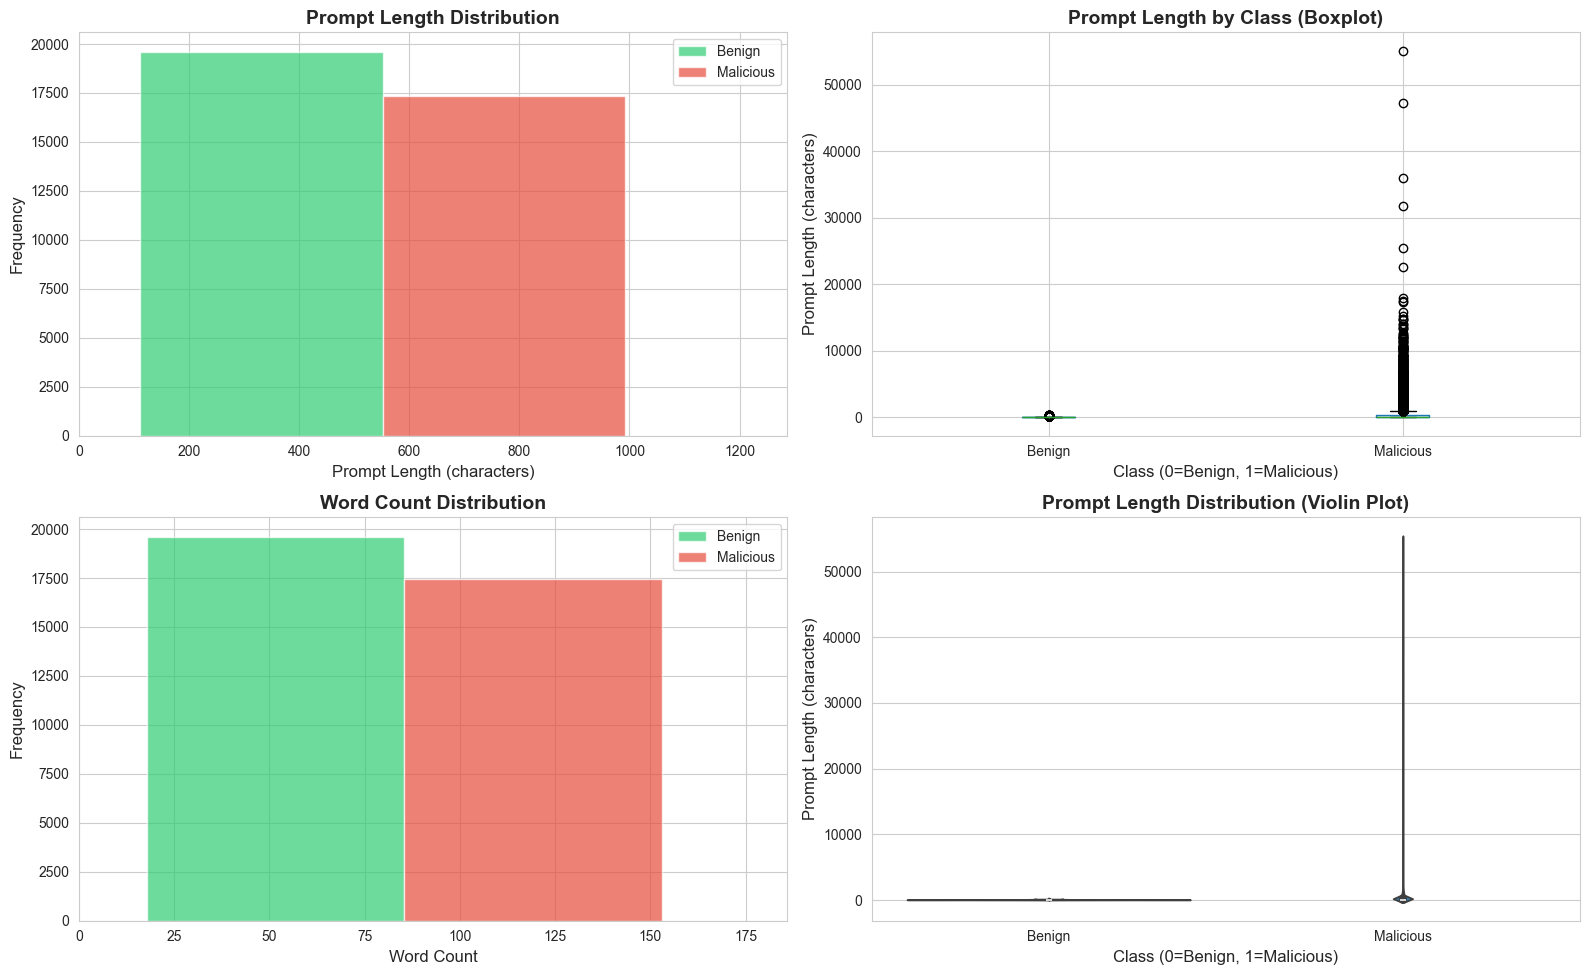

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Character length distribution
benign_lengths = df[df[label_col] == 0]['prompt_length']
malicious_lengths = df[df[label_col] == 1]['prompt_length']

axes[0, 0].hist([benign_lengths, malicious_lengths], bins=50, label=['Benign', 'Malicious'], 
                color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0, 0].set_xlabel('Prompt Length (characters)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Prompt Length Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, df['prompt_length'].quantile(0.95))  # Ignore extreme outliers for viz

# Box plot
df.boxplot(column='prompt_length', by=label_col, ax=axes[0, 1])
axes[0, 1].set_xlabel('Class (0=Benign, 1=Malicious)', fontsize=12)
axes[0, 1].set_ylabel('Prompt Length (characters)', fontsize=12)
axes[0, 1].set_title('Prompt Length by Class (Boxplot)', fontsize=14, fontweight='bold')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Benign', 'Malicious'])

# Word count distribution
benign_words = df[df[label_col] == 0]['word_count']
malicious_words = df[df[label_col] == 1]['word_count']

axes[1, 0].hist([benign_words, malicious_words], bins=50, label=['Benign', 'Malicious'],
                color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[1, 0].set_xlabel('Word Count', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, df['word_count'].quantile(0.95))

# Violin plot
sns.violinplot(data=df, x=label_col, y='prompt_length', ax=axes[1, 1])
axes[1, 1].set_xlabel('Class (0=Benign, 1=Malicious)', fontsize=12)
axes[1, 1].set_ylabel('Prompt Length (characters)', fontsize=12)
axes[1, 1].set_title('Prompt Length Distribution (Violin Plot)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(['Benign', 'Malicious'])

plt.suptitle('')  # Remove the automatic title
plt.tight_layout()
plt.savefig('../notebooks/length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
print("\n" + "="*50)
print("RANDOM SAMPLE INSPECTION")
print("="*50)

# Sample benign prompts
print("\n--- BENIGN PROMPTS (Random Sample) ---\n")
benign_sample = df[df[label_col] == 0].sample(10, random_state=42)
for idx, row in benign_sample.iterrows():
    print(f"{idx}. [{len(row[prompt_col])} chars] {row[prompt_col][:150]}...")
    print()

# Sample malicious prompts
print("\n--- MALICIOUS PROMPTS (Random Sample) ---\n")
malicious_sample = df[df[label_col] == 1].sample(10, random_state=42)
for idx, row in malicious_sample.iterrows():
    print(f"{idx}. [{len(row[prompt_col])} chars] {row[prompt_col][:150]}...")
    print()


RANDOM SAMPLE INSPECTION

--- BENIGN PROMPTS (Random Sample) ---

20316. [45 chars] What is the infant mortality rate for Europe?...

31251. [64 chars] Do white people unconsciously view other races as more inferior?...

32500. [38 chars] What colors do you mix to make maroon?...

36587. [55 chars] Why is plasma considered as the fourth state of matter?...

23450. [51 chars] Would it be better if humans would have two hearts?...

17759. [47 chars] Are Chinese people racist against black people?...

2374. [62 chars] Are there free software programs for value investing analysis?...

3208. [84 chars] Why we need an error term in regression model? What is its statistical distribution?...

23417. [147 chars] Whenever its about “her” its a very special feeling. Tried hard to forget her but she's alwys spcl. Should I stop talking to her even as a friend ?...

22467. [41 chars] in lower manhattan. they are at a new bar...


--- MALICIOUS PROMPTS (Random Sample) ---

20241. [338 chars] Im usin

In [14]:
print("\n" + "="*50)
print("PATTERN ANALYSIS")
print("="*50)

# Common injection keywords
injection_keywords = [
    'ignore', 'disregard', 'bypass', 'system', 'prompt', 
    'instructions', 'previous', 'above', 'admin', 'sudo',
    'jailbreak', 'DAN', 'developer mode', 'override', 'forget'
]

print("\nChecking for injection keywords in malicious prompts:")
malicious_prompts = df[df[label_col] == 1][prompt_col].astype(str).str.lower()

for keyword in injection_keywords:
    count = malicious_prompts.str.contains(keyword, regex=False).sum()
    pct = 100 * count / len(malicious_prompts)
    if count > 0:
        print(f"  '{keyword}': {count:,} occurrences ({pct:.1f}%)")

# Check special characters
print("\nSpecial character analysis:")
df['has_special_chars'] = df[prompt_col].astype(str).str.contains(r'[<>{}[\]\\]', regex=True)
special_by_class = df.groupby(label_col)['has_special_chars'].mean()
print(f"Benign prompts with special chars: {100*special_by_class[0]:.1f}%")
print(f"Malicious prompts with special chars: {100*special_by_class[1]:.1f}%")


PATTERN ANALYSIS

Checking for injection keywords in malicious prompts:
  'ignore': 1,139 occurrences (5.8%)
  'disregard': 891 occurrences (4.5%)
  'bypass': 883 occurrences (4.5%)
  'system': 765 occurrences (3.9%)
  'prompt': 921 occurrences (4.7%)
  'instructions': 908 occurrences (4.6%)
  'previous': 1,401 occurrences (7.1%)
  'above': 1,414 occurrences (7.2%)
  'admin': 170 occurrences (0.9%)
  'sudo': 16 occurrences (0.1%)
  'jailbreak': 144 occurrences (0.7%)
  'developer mode': 64 occurrences (0.3%)
  'override': 143 occurrences (0.7%)
  'forget': 1,020 occurrences (5.2%)

Special character analysis:
Benign prompts with special chars: 0.3%
Malicious prompts with special chars: 16.8%


In [15]:
print("\n" + "="*50)
print("EDA SUMMARY")
print("="*50)

summary = {
    'Total Samples': len(df),
    'Benign Samples': (df[label_col] == 0).sum(),
    'Malicious Samples': (df[label_col] == 1).sum(),
    'Class Imbalance Ratio': f"{imbalance_ratio:.2f}:1",
    'Missing Values': df.isnull().sum().sum(),
    'Duplicate Prompts': total_duplicates,
    'Avg Prompt Length (chars)': f"{df['prompt_length'].mean():.1f}",
    'Avg Word Count': f"{df['word_count'].mean():.1f}",
    'Shortest Prompt': df['prompt_length'].min(),
    'Longest Prompt': df['prompt_length'].max()
}

for key, value in summary.items():
    print(f"{key:.<40} {value}")


EDA SUMMARY
Total Samples........................... 39234
Benign Samples.......................... 19617
Malicious Samples....................... 19617
Class Imbalance Ratio................... 1.00:1
Missing Values.......................... 0
Duplicate Prompts....................... 0
Avg Prompt Length (chars)............... 283.0
Avg Word Count.......................... 43.0
Shortest Prompt......................... 1
Longest Prompt.......................... 55089


# EDA Findings - Session 1

## Dataset Overview
- **Total samples**: 39234
- **Features**: prompt text + binary label
- **Data quality**: Data is well balanced with a range of prompt lengths and a good distribution of words. Prompts do not completely rely on generic malicious words and are of various contexts and intents.

## Key Observations

### 1. Class Distribution
- Benign: 50% 
- Malicious: 50%
- **Imbalance ratio**: 1.00:1
- **Action needed**: No action required.

### 2. Prompt Characteristics
- **Length patterns**: Malicious prompts tend to be much longer than Benign prompts in both average length and extremes.
- **Word count**: Similar to prompt length, Malicious prompts tend to be contain more words than Benign ones.
- **Special characters**: 16.8% of Malicious prompts use special characters, as opposed to 0.3% of Benign prompts.

### 3. Data Quality Issues
- **Duplicates**: 0 Duplicates
- **Missing values**: 0 Missing Values
- **Conflicting labels**: 0 Conflicting Labels

### 4. Patterns in Malicious Prompts
- Malicious prompts tend to be very specific whilst layering in the malicious instructions.
- above, previous, forget, ignore.
- 16.8% of Malicious prompts use special characters

In [17]:
# Save cleaned dataset with computed features. New Colums: Prompt, isMalicious, prompt_length, word_count, has_special_chars
df.to_csv('../data/processed/prompts_with_features.csv', index=False)
print("\n✓ Saved processed data to data/processed/prompts_with_features.csv")


✓ Saved processed data to data/processed/prompts_with_features.csv
